In [1]:
from light_curves import LightCurve
from exposures import Calexp
from task import Run
import numpy as np

In [ ]:
n_points = [10,30,50,70,100]
levels = [20,11,10,9]
problems = []

for n in n_points:
    for lvl in levels:
        print(f"||||||||||||||----------- POINT: {n} ------ LEVEL: {lvl} -----------||||||||||||||")
        process = Run(name = f"run_{n}pts_{lvl}lvl", htm_level=lvl)
        process.inject_task()
        schema = process.measure_task()
        params = [{"t_0": 60700.5, "t_E": 110, "u_0": 0.5, "m_base": m} for m in np.linspace(18,24,n)]
        process.add_lc(params[0], ra=57.59451632893858, dec=-32.481152201226145)
        for p in params[1:]:
            process.add_lc(p, dist=0.2)
        process.sky_map()
        process.log_task("Add and simulate light curves")
        for j, dataId in enumerate(process.calexp_dataIds[:10]):
            print(f" ------ CALEXP {j} ------")
            calexp = Calexp(dataId)
            injected_exp, injected_points = process.inject_calexp(calexp, save_fit=f"calexp_{j}.fit")
            if injected_exp != None:
                sources = process.measure_calexp(injected_exp, schema)
                flux, flux_err = process.find_flux(sources, injected_points, save=dataId)
                for f, ferr, lc_idx in zip(flux, flux_err, injected_points):
                    lc = process.inj_lc[lc_idx]
                    mag, mag_err = calexp.get_mag(f, ferr)
                    lc.add_mag(mag, mag_err, dataId)
                    print(f"ra = {lc.ra}, dec = {lc.dec}")
                    print("Measured ", mag, mag_err)
                    print("Injected ", lc.data["mag_sim"][j])
                    if abs(mag-lc.data["mag_sim"][j])>1:
                        problems.append((calexp,source))
        process.save_lc()
        process.save_time_log()
        process.time_analysis()



||||||||||||||----------- POINT: 10 ------ LEVEL: 20 -----------||||||||||||||
(ra,dec) = (57.59451632893858, -32.481152201226145)/nHTM_ID = 9871854450032 - HTM_level=20 (bounded by a circle of radius ~0.27 arcsec.)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/share/eups/Linux64/daf_butler/g588e17ab67+fac83bd63d/python/lsst/daf/butler/registry/queries/_structs.py:401: FutureWarning: Dimension 'htm20' should no longer be used in data IDs. Use the region 'OVERLAPS' operator in the where clause instead. Will be removed after v28.
  warnings.warn(


Found 145 calexps


/home/karennowo/DP0_microlensing/light_curves.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data_filtered], ignore_index=True)
Loading calexps:  17%|█▋        | 25/145 [00:50<04:16,  2.14s/it]

## Run results

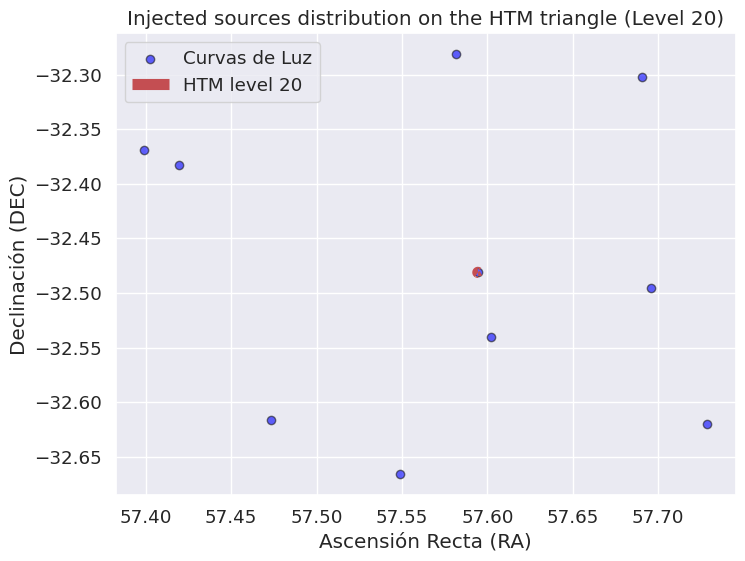

In [29]:
from lsst.sphgeom import HtmPixelization, UnitVector3d, LonLat
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
ra_vals = [lc.ra for lc in process.inj_lc]
dec_vals = [lc.dec for lc in process.inj_lc]
pixelization = HtmPixelization(process.htm_level)
htm_triangle = pixelization.triangle(process.inj_lc[0].htm_id)
tri_ra_dec = []
for vertex in htm_triangle.getVertices():
    lon = LonLat.longitudeOf(vertex).asDegrees()
    lat = LonLat.latitudeOf(vertex).asDegrees()
    tri_ra_dec.append((lon, lat))
htm_polygon = Polygon(tri_ra_dec)
x, y = htm_polygon.exterior.xy
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ra_vals, dec_vals, color='blue', label="Curvas de Luz", alpha=0.6, edgecolor='k')
ax.set_xlabel("Ascensión Recta (RA)")
ax.set_ylabel("Declinación (DEC)")
ax.set_title(f"Injected sources distribution on the HTM triangle (Level {process.htm_level})")

ax.plot(x, y, color="r", linewidth=8, label=f"HTM level {process.htm_level}", linestyle="--")
ax.legend()
plt.grid(True)
plt.show()

In [17]:
lc.htm_id

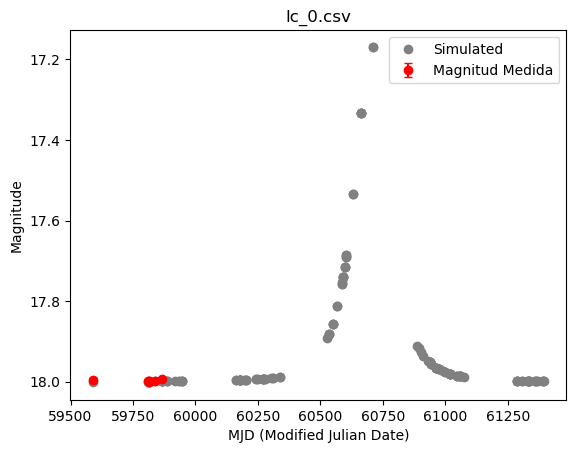

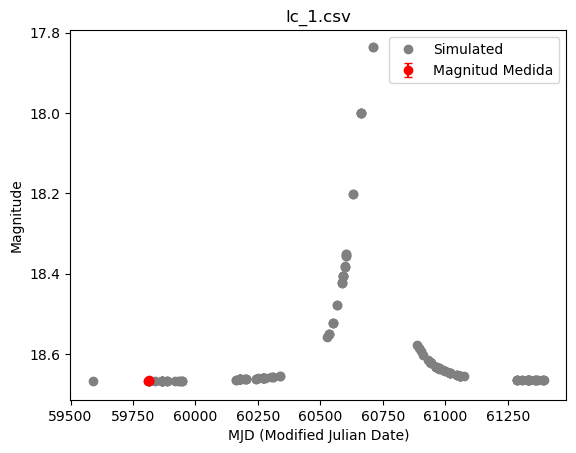

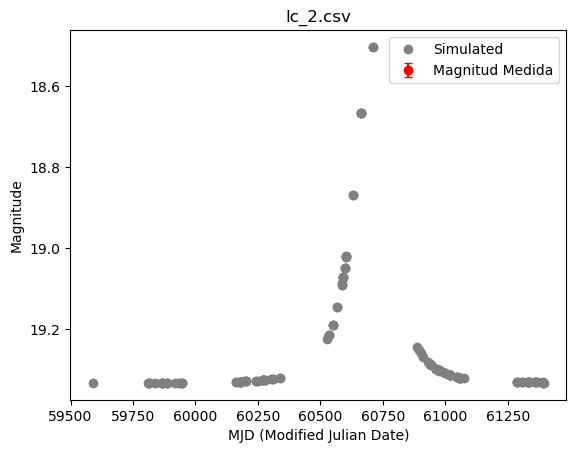

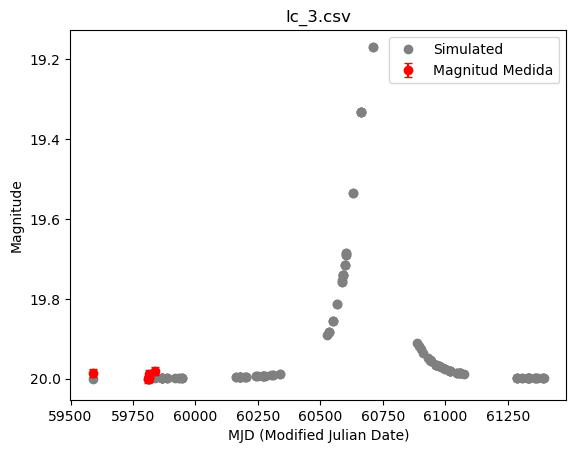

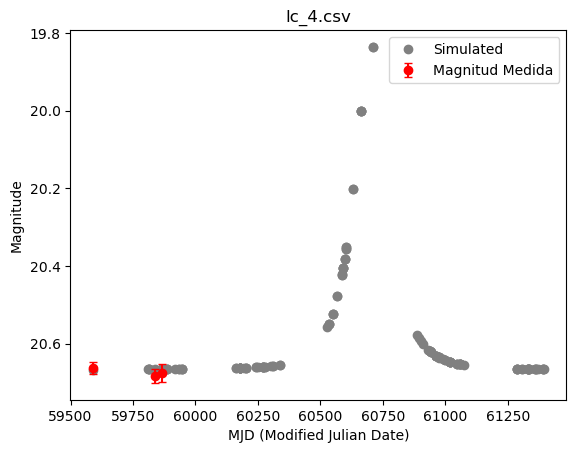

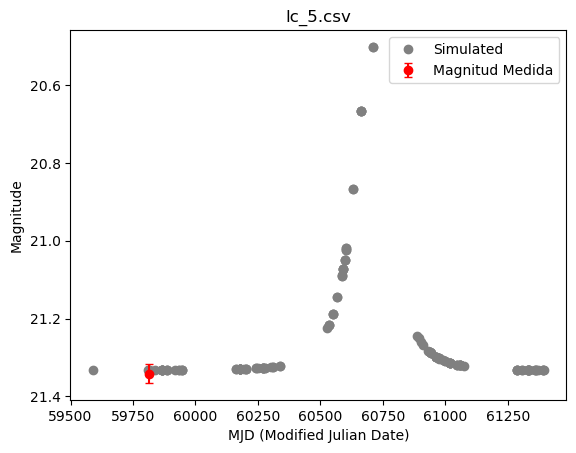

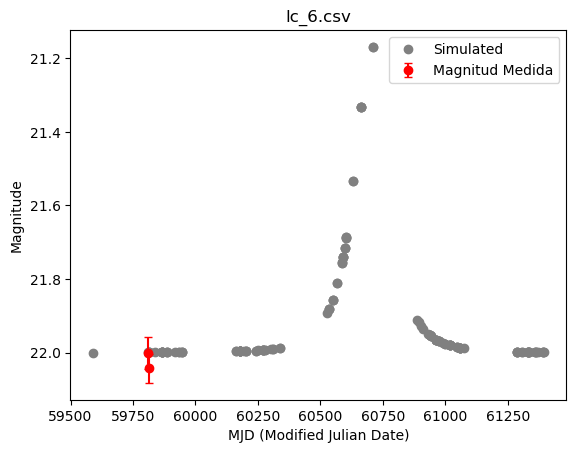

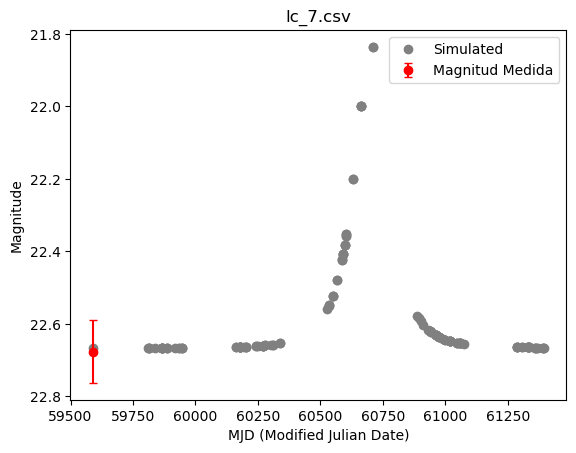

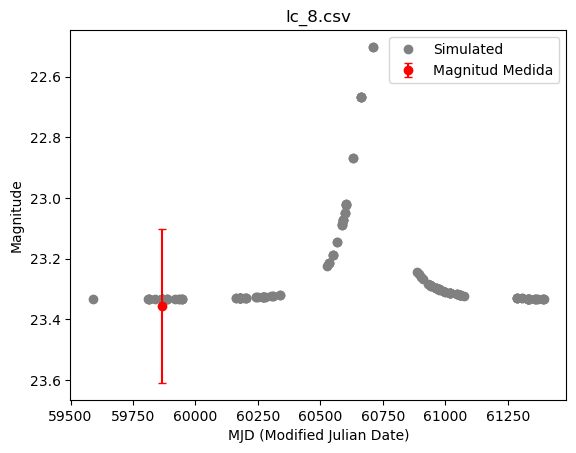

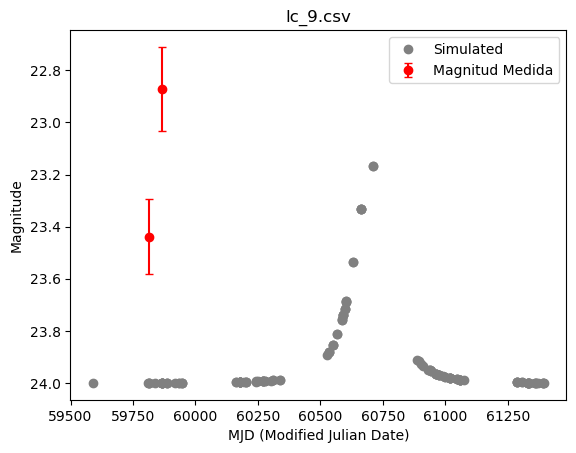

In [12]:
# Plot light curves from a run
import pandas as pd
n=10; lvl = 20
path = f"runs/run_{n}pts_{lvl}lvl/"
for lc_path in sorted([file for file in os.listdir(path) if file.startswith("lc")]):
    lc = LightCurve(data=pd.read_csv(path+lc_path))
    lc.plot(title = lc_path)


In [19]:
n_points = [10,30,50,70,100]
levels = [20,11,10,9]
durations = np.zeros((len(n_points), len(levels)))
durations_normalized = np.zeros((len(n_points), len(levels)))
points = np.zeros((len(n_points), len(levels)))
points_normalized = np.zeros((len(n_points), len(levels)))
for i, n in enumerate(n_points):
    for j, lvl in enumerate(levels):
        time_path = f"runs/run_{n}pts_{lvl}lvl/time_log.csv"
        df = pd.read_csv(time_path)
        points[i,j] = sum(df[df["task"]=="Finding points"]["detail"])
        points_normalized[i,j] = sum(df[df["task"]=="Finding points"]["detail"])/n
        times = df["time"].values
        total_duration = times[-1]-times[0]
        durations[i,j] = total_duration/60
        durations_normalized[i,j] = (total_duration/60)/n
        

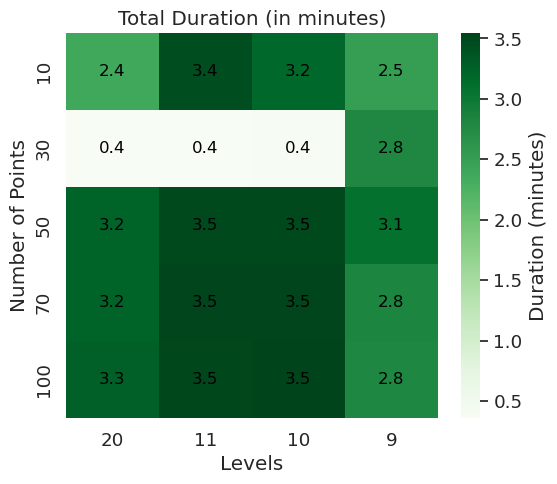

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)  # Para aumentar el tamaño de las etiquetas
ax = sns.heatmap(durations, cmap='Greens', annot=True, fmt=".1f", 
                 xticklabels=levels, yticklabels=n_points, 
                 cbar_kws={'label': 'Duration (minutes)'}, 
                 annot_kws={'size': 12, 'color': 'black'})
plt.xlabel('Levels')
plt.ylabel('Number of Points')
plt.title('Total Duration (in minutes)')
plt.show()


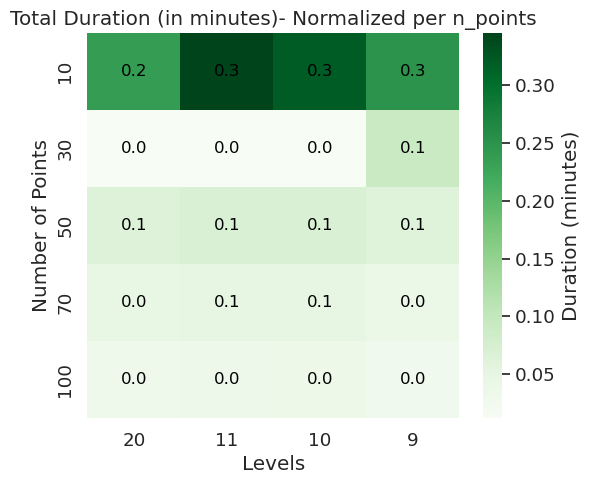

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)  # Para aumentar el tamaño de las etiquetas
ax = sns.heatmap(durations_normalized, cmap='Greens', annot=True, fmt=".1f", 
                 xticklabels=levels, yticklabels=n_points, 
                 cbar_kws={'label': 'Duration (minutes)'}, 
                 annot_kws={'size': 12, 'color': 'black'})
plt.xlabel('Levels')
plt.ylabel('Number of Points')
plt.title('Total Duration (in minutes)- Normalized per n_points')
plt.show()


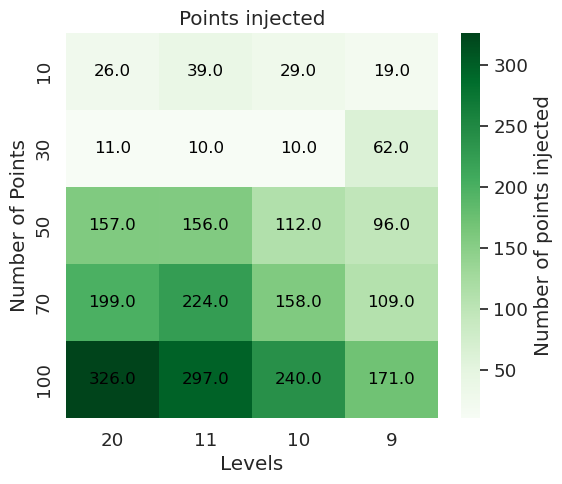

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)  # Para aumentar el tamaño de las etiquetas
ax = sns.heatmap(points, cmap='Greens', annot=True, fmt=".1f", 
                 xticklabels=levels, yticklabels=n_points, 
                 cbar_kws={'label': 'Number of points injected'}, 
                 annot_kws={'size': 12, 'color': 'black'})
plt.xlabel('Levels')
plt.ylabel('Number of Points')
plt.title('Points injected')
plt.show()


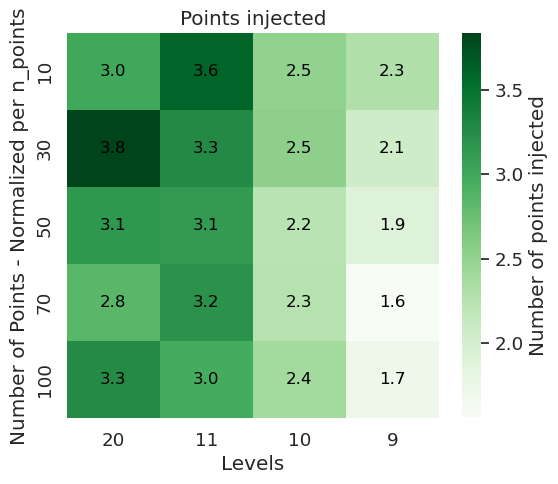

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)  # Para aumentar el tamaño de las etiquetas
ax = sns.heatmap(points_normalized, cmap='Greens', annot=True, fmt=".1f", 
                 xticklabels=levels, yticklabels=n_points, 
                 cbar_kws={'label': 'Number of points injected'}, 
                 annot_kws={'size': 12, 'color': 'black'})
plt.xlabel('Levels')
plt.ylabel('Number of Points - Normalized per n_points')
plt.title('Points injected')
plt.show()


In [24]:
sum(df[df["task"]=="Finding points"]["detail"])

171.0